In [1]:
import geopandas as gpd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns


import mapclassify as mc
from scipy.stats import norm
import contextily
from pysal.lib import weights  # Spatial weights
from pysal.explore import esda
import shapely
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import libpysal as ps 
%matplotlib inline 

import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix

import shap
shap.initjs()

/Users/hucongying/anaconda3/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/74/ch5llxvd3klg6n6_l6_s335w0000gn/T/ipykernel_1398/2655620902.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https:

## Load data

In [2]:
scot_simd=gpd.read_file('data/SG_SIMD_2020/SG_SIMD_2020.shp')

In [3]:
df1=pd.read_csv('data/Final_results.csv')
df2=pd.read_csv('data/POI_diversity.csv')

In [4]:
df2

Unnamed: 0   DataZone  Richness  Shannon entropy  Simpson index  \
0             0  S01009758         2             1.00           0.50   
1             1  S01009759         7             2.53           0.23   
2             2  S01009760        22             5.06           0.04   
3             3  S01009761         6             2.52           0.18   
4             4  S01009762        11             3.68           0.09   
..          ...        ...       ...              ...            ...   
740         740  S01010499        17             4.97           0.04   
741         741  S01010500        11             3.08           0.15   
742         742  S01010501         7             2.61           0.21   
743         743  S01010502         5             2.25           0.22   
744         744  S01010503        12             3.80           0.09   

     Join_Count     Shape_Area  poi_ratio  
0             2   78490.309008   0.254809  
1            20  136091.515542   1.469599  
2            72  332345.088422   2.166423  
3             8  156078.015080   0.512564  
4            20  150737.851165   1.326807  
..          ...            ...        ...  
740          76  244941.600066   3.102780  
741          28  218303.033646   1.282621  
742          19  233830.299216   0.812555  
743           8  241424.225068   0.331367  
744          34  204458.577799   1.662929  

[745 rows x 8 columns]

In [5]:
df3=pd.read_csv('Old_buildings_pro.csv')

In [6]:
df4=pd.read_excel('data/GDP2020.xlsx',sheet_name='Table 2',header=1) #从第二行开始读作为表头

In [7]:
df5=pd.read_excel('data/Population_TabA.xlsx',sheet_name='TabA',header=2)

In [8]:
df6=pd.read_csv('data/Occupation.csv')

In [9]:
df7=pd.read_excel('data/JL1.xls')

In [10]:
df4=df4[df4['LAD name']=='Glasgow City']

In [11]:
df4.columns

Index([  'DZ code',   'DZ name',  'LAD code',  'LAD name', 'ITL1 code',
       'ITL1 name',        1998,        1999,        2000,        2001,
              2002,        2003,        2004,        2005,        2006,
              2007,        2008,        2009,        2010,        2011,
              2012,        2013,        2014,        2015,        2016,
              2017,        2018,        2019,        2020],
      dtype='object')

In [12]:
df4=df4[['DZ code',2020]]

In [13]:
df4.columns=['DataZone','GVA2020']

In [14]:
df5=df5[df5['Council area']=='Glasgow City']
df5=df5[['DataZone2011Code','Total population']]


In [15]:
df5.columns=['DataZone','Total_population']

In [16]:
df5

DataZone  Total_population
3253  S01009758             583.0
3254  S01009759             901.0
3255  S01009760             843.0
3256  S01009761             787.0
3257  S01009762            1327.0
...         ...               ...
3994  S01010499             838.0
3995  S01010500             975.0
3996  S01010501            1121.0
3997  S01010502             788.0
3998  S01010503             641.0

[746 rows x 2 columns]

In [17]:
df=gla_geo.merge(df1,how='left',on='DataZone')

df=df.merge(df2,how='left',on='DataZone')

df=df.merge(df3,how='left',on='DataZone')

df=df.merge(df4,how='left',on='DataZone')

df=df.merge(df5,how='left',on='DataZone')

df=df.merge(df6,how='left',on='DataZone')

df=df.merge(df7,how='left',on='DataZone')

In [72]:
type(df)

pandas.core.frame.DataFrame

In [18]:
df.columns

Index(['DataZone', 'Quintilev2', 'geometry', 'OBJECTID_x', 'Zone_area',
       'junction_count', 'junction_density', 'tourist_count',
       'tourist_density', 'industry_count', 'industry_density', 'office_count',
       'office_density', 'resid_count', 'resid_density', 'NTL_MEAN',
       'property_area', 'Number_of_Buildings', 'Building_Density',
       'Number_of_Busstops', 'busstops_Density',
       'Number_of_consumptionrelated', 'consumptionrelated_Density',
       'Buildingarea_divide_Datazone', 'VARIANCE_height', 'FAR',
       'Unnamed: 0_x', 'Richness', 'Shannon entropy', 'Simpson index',
       'Join_Count', 'Shape_Area_x', 'poi_ratio', 'Unnamed: 0_y',
       'Old_buildings_pro', 'GVA2020', 'Total_population',
       'Number_of_Occupationrelated', 'Shape_Area_y',
       'Occupationrelated_Density', 'OBJECTID_y', 'ZONE_CODE', 'COUNT', 'AREA',
       'MIN', 'MAX', 'RANGE', 'MEAN', 'STD', 'SUM', 'MEDIAN', 'PCT90'],
      dtype='object')

In [19]:
df['pop_density']=df['Total_population']/df['Zone_area']
df['Normalized_GVA']=df['GVA2020']/df['Zone_area']
df['Normalized_BHV']=df['VARIANCE_height']/df['Zone_area']


In [20]:
df['Normalized_Brightness']=df['SUM']/df['AREA']

In [21]:
df['Quintilev2']=df['Quintilev2'].astype('str')


In [22]:
df6

DataZone  Number_of_Occupationrelated     Shape_Area  \
0    S01009760                       1308.0  332345.088422   
1    S01009762                        176.0  150737.851165   
2    S01009765                        331.0  352414.640841   
3    S01009766                        250.0   83071.211025   
4    S01009772                        277.0   87411.706504   
..         ...                          ...            ...   
370  S01010489                       2168.0  558822.330884   
371  S01010494                        204.0  230667.806945   
372  S01010495                        378.0  127349.002281   
373  S01010497                        765.0  571920.761192   
374  S01010499                        790.0  244941.600066   

     Occupationrelated_Density  
0                  3935.668212  
1                  1167.589949  
2                   939.234531  
3                  3009.466179  
4                  3168.911935  
..                         ...  
370                3879.587268  
371                 884.388692  
372                2968.221134  
373                1337.597884  
374                3225.258591  

[375 rows x 4 columns]

In [23]:
df

DataZone Quintilev2                                           geometry  \
0    S01009758          4  POLYGON ((254366.687 658648.165, 254302.649 65...   
1    S01009759          1  POLYGON ((254197.000 660082.000, 254187.000 66...   
2    S01009760          1  POLYGON ((254419.100 659330.500, 254431.196 65...   
3    S01009761          3  POLYGON ((254085.000 658830.000, 254073.000 65...   
4    S01009762          1  POLYGON ((253971.926 659497.041, 253975.149 65...   
..         ...        ...                                                ...   
741  S01010499          1  POLYGON ((251775.000 671648.000, 251833.000 67...   
742  S01010500          1  POLYGON ((251511.000 671262.000, 251522.001 67...   
743  S01010501          1  POLYGON ((251627.000 671643.000, 251610.000 67...   
744  S01010502          2  POLYGON ((251100.354 672000.127, 251110.987 67...   
745  S01010503          1  POLYGON ((251277.869 670970.220, 251277.036 67...   

     OBJECTID_x  Zone_area  junction_count  junction_density  tourist_count  \
0             1   0.078490             8.0        101.923447            0.0   
1             2   0.136092             6.0         44.087980            3.0   
2             3   0.332345            32.0         96.285451            0.0   
3             4   0.156078            10.0         64.070523            1.0   
4             5   0.150738            18.0        119.412608            1.0   
..          ...        ...             ...               ...            ...   
741         740   0.244942            19.0         77.569510            2.0   
742         741   0.218303            19.0         87.034980            2.0   
743         742   0.233830            23.0         98.361933            2.0   
744         745   0.241424            22.0         91.125901            0.0   
745         746   0.204459            17.0         83.146434            1.0   

     tourist_density  industry_count  ...       RANGE      MEAN        STD  \
0           0.000000             0.0  ...  237.533997  1.233110   4.456366   
1          22.043990             0.0  ...  243.714593  1.335502   4.309553   
2           0.000000             8.0  ...  254.974503  2.009213   9.980061   
3           6.407052             1.0  ...  100.719902  1.224504   2.483237   
4           6.634034             0.0  ...  187.090607  1.301274   3.014657   
..               ...             ...  ...         ...       ...        ...   
741         8.165212             0.0  ...  248.611596  2.833050  10.727741   
742         9.161577             0.0  ...  239.343994  1.624646   5.867560   
743         8.553212             0.0  ...  224.128494  1.412368   4.500635   
744         0.000000             1.0  ...  234.792694  1.327951   4.601257   
745         4.890967             0.0  ...  239.045105  2.815651  10.599676   

               SUM  MEDIAN   PCT90  pop_density  Normalized_GVA  \
0     56990.634925  0.9999  0.9999  7427.671229       54.809522   
1    107055.158125  0.9999  0.9999  6620.544980       43.873771   
2    393317.437427  0.9999  0.9999  2536.519839      193.885096   
3    112573.554774  0.9999  0.9999  5042.350132       10.615452   
4    115528.377952  0.9999  0.9999  8803.362856       29.900300   
..             ...     ...     ...          ...             ...   
741  408755.233153  0.9999  0.9999  3421.223670      170.933000   
742  208908.351053  0.9999  0.9999  4466.268699       10.324945   
743  194515.557279  0.9999  0.9999  4794.075088        2.209042   
744  188821.336121  0.9999  0.9999  3263.964108        7.841930   
745  339086.093970  0.9999  0.9999  3135.109662       16.652303   

     Normalized_BHV  Normalized_Brightness  
0         32.097893               0.726293  
1         77.294066               0.786602  
2         34.120655               1.183413  
3         10.343465               0.721225  
4         69.484806               0.766441  
..              ...                    ...  
741       12.254673               1.668

In [24]:
df_geo=df[['DataZone','geometry','Normalized_Brightness','Quintilev2',
         'Buildingarea_divide_Datazone','FAR',
         'consumptionrelated_Density','tourist_density','industry_density','Occupationrelated_Density','resid_density',
         'Shannon entropy','Richness','Simpson index','poi_ratio','Normalized_BHV','Old_buildings_pro',
         'junction_density','busstops_Density',
         'pop_density','Normalized_GVA']]

In [25]:
## Make a list of all columns that are currently object dtype
df=df[['Normalized_Brightness',
         'Buildingarea_divide_Datazone','FAR',
         'consumptionrelated_Density','tourist_density','industry_density','Occupationrelated_Density','resid_density',
         'Shannon entropy','Richness','Simpson index','poi_ratio','Normalized_BHV','Old_buildings_pro',
         'junction_density','busstops_Density',
         'pop_density','Normalized_GVA']]

In [26]:
df.columns

Index(['Normalized_Brightness', 'Buildingarea_divide_Datazone', 'FAR',
       'consumptionrelated_Density', 'tourist_density', 'industry_density',
       'Occupationrelated_Density', 'resid_density', 'Shannon entropy',
       'Richness', 'Simpson index', 'poi_ratio', 'Normalized_BHV',
       'Old_buildings_pro', 'junction_density', 'busstops_Density',
       'pop_density', 'Normalized_GVA'],
      dtype='object')

In [27]:
df

Normalized_Brightness  Buildingarea_divide_Datazone       FAR  \
0                 0.726293                      0.194114  0.479066   
1                 0.786602                      0.125103  0.646000   
2                 1.183413                      0.243887  0.871436   
3                 0.721225                      0.139742  0.318583   
4                 0.766441                      0.115418  0.576168   
..                     ...                           ...       ...   
741               1.668647                      0.147014  0.598970   
742               0.956906                      0.109949  0.392381   
743               0.831875                      0.113939  0.383483   
744               0.782154                      0.070313  0.000000   
745               1.658400                      0.141963  0.000000   

     consumptionrelated_Density  tourist_density  industry_density  \
0                      0.000000         0.000000          0.000000   
1                      0.000000        22.043990          0.000000   
2                     15.044603         0.000000         24.071363   
3                      6.407052         6.407052          6.407052   
4                     19.902101         6.634034          0.000000   
..                          ...              ...               ...   
741                   61.239087         8.165212          0.000000   
742                    9.161577         9.161577          0.000000   
743                    4.276606         8.553212          0.000000   
744                    0.000000         0.000000          4.142086   
745                   29.345797         4.890967          0.000000   

     Occupationrelated_Density  resid_density  Shannon entropy  Richness  \
0                          NaN    2675.490494             1.00       2.0   
1                          NaN     595.187728             2.53       7.0   
2                  3935.668212     565.677022             5.06      22.0   
3                          NaN    2204.025979             2.52       6.0   
4                  1167.589949     563.892873             3.68      11.0   
..                         ...            ...              ...       ...   
741                3225.258591     498.077909             4.97      17.0   
742                        NaN    1218.489717             3.08      11.0   
743                        NaN    1586.620747             2.61       7.0   
744                        NaN    1023.095349             2.25       5.0   
745                        NaN     523.333438             3.80      12.0   

     Simpson index  poi_ratio  Normalized_BHV  Old_buildings_pro  \
0             0.50   0.254809       32.097893               0.00   
1             0.23   1.469599       77.294066               0.00   
2             0.04   2.166423       34.120655               0.53   
3             0.18   0.512564       10.343465               0.00   
4             0.09   1.326807       69.484806               0.01   
..             ...        ...             ...                ...   
741           0.04   3.102780       12.254673               0.07   
742           0.15   1.282621       20.967277               0.00   
743           0.21   0.812555       31.429205               0.01   
744           0.22   0.331367        0.000000               0.00   
745           0.09   1.662929        0.000000               0.04   

     junction_density  busstops_Density  pop_density  Normalized_GVA  
0          101.923447          0.000000  7427.671229       54.809522  
1           44.087980         51.435977  6620.544980       43.873771  
2           96.285451         24.071365  2536.519839      193.885096  
3           64.070523         12.814105  5042.350132       10.615452  
4          119.412608         19.902101  8803.362856       29.900300  
..                ...               ...          ...             ...  
741         77.569510         40.826058  3421.223670      170.933000  
742         87.034980    

In [28]:
df.columns=['NTL',
            'BD','FAR',
            'CPOI','TPOI','MPOI','OPOI','HPOI',
            'SE','RI','SI','PR','BHV','OBP',
            'JD','BSD',
            'PD','GVA']

In [29]:
df_geo.columns=['DataZone','geometry','NTL','Quintilev2',
                'BD','FAR',
                'CPOI','TPOI','MPOI','OPOI','HPOI',
                'SE','RI','SI','PR','BHV','OBP',
                'JD','BSD',
                'PD','GVA']

In [30]:
df.isnull().sum()

NTL       0
BD        0
FAR       0
CPOI      0
TPOI      0
MPOI      0
OPOI    371
HPOI      0
SE        1
RI        1
SI        1
PR        1
BHV       0
OBP       2
JD        0
BSD       0
PD        0
GVA       0
dtype: int64

In [31]:
df_geo=df_geo.fillna(0)
df=df.fillna(0)

## Exploratory analysis

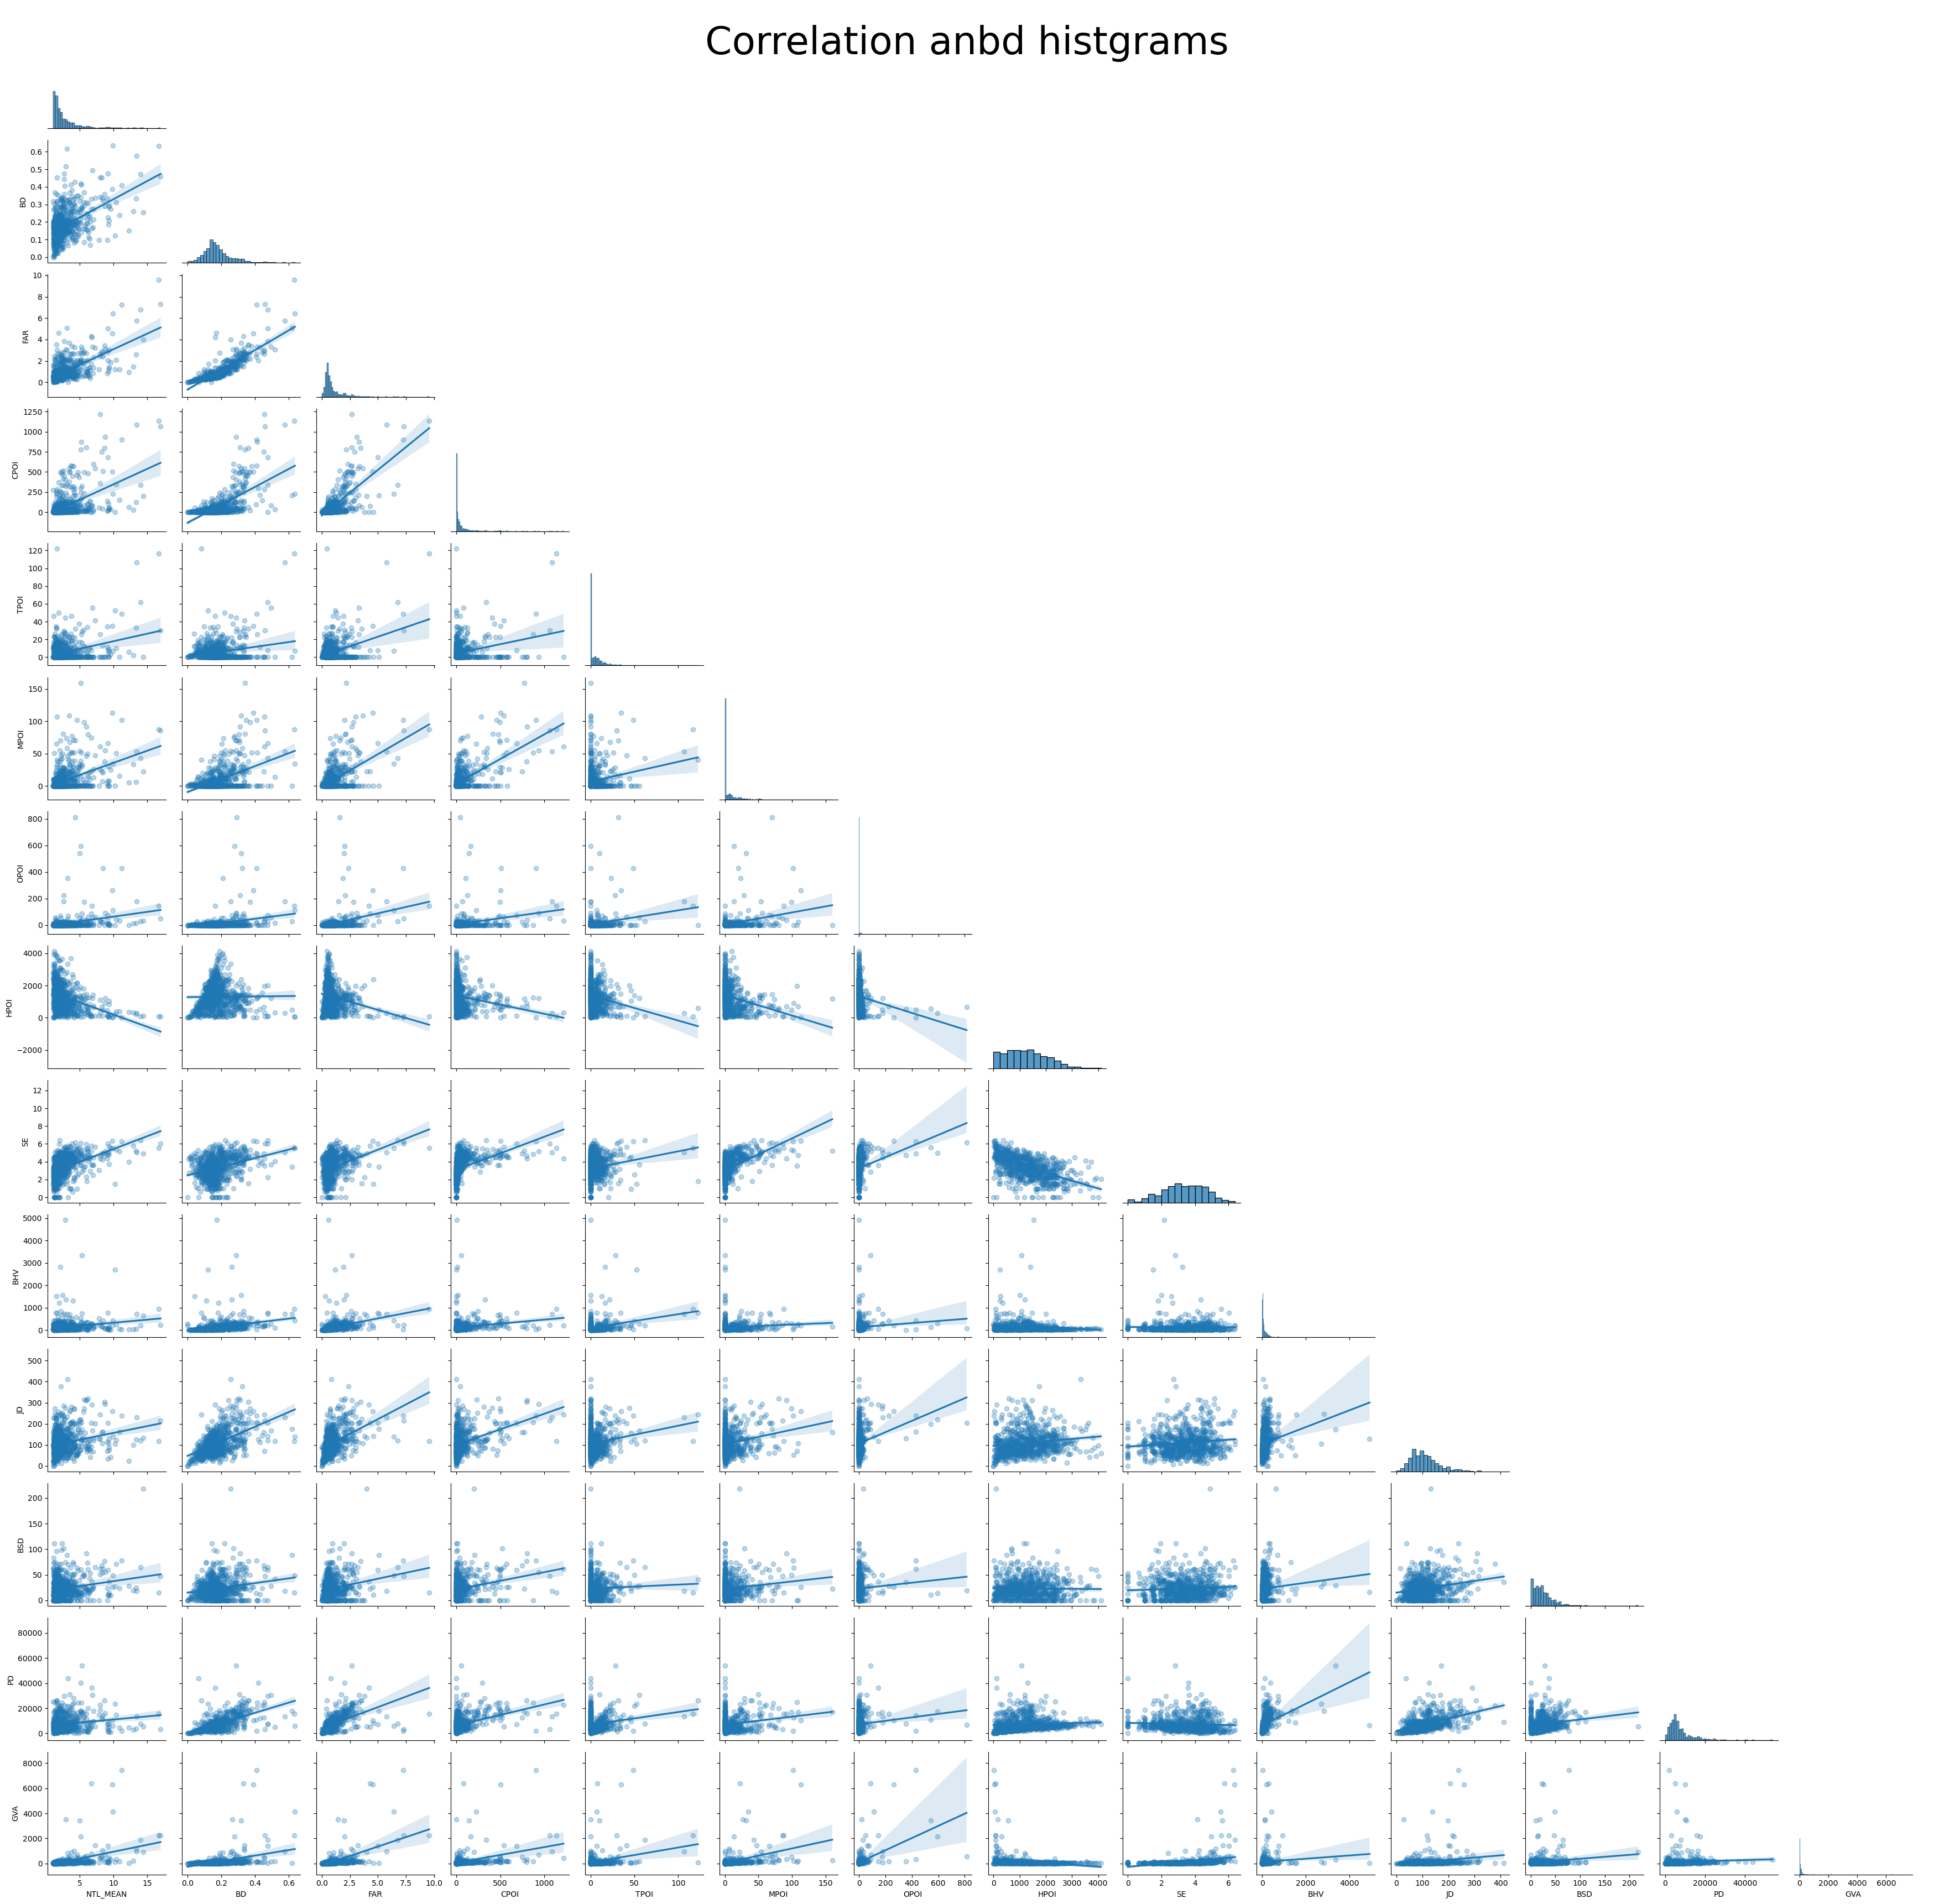

In [29]:
variables = ['NTL_MEAN',
            'BD','FAR',
            'CPOI','TPOI','MPOI','OPOI','HPOI',
           'SE','BHV',
           'JD','BSD',
           'PD','GVA']
mpl.rcParams["axes.labelsize"] = 20
g = sns.PairGrid(df_geo,vars=variables,corner=True)
plt.subplots_adjust(top=0.99)
g.map_diag(sns.histplot)
g.map_offdiag(sns.regplot,scatter_kws={'alpha':0.3})
g.add_legend()
g.fig.suptitle('Correlation anbd histgrams',fontsize=50)
plt.savefig('Scatter.jpg')
plt.show()


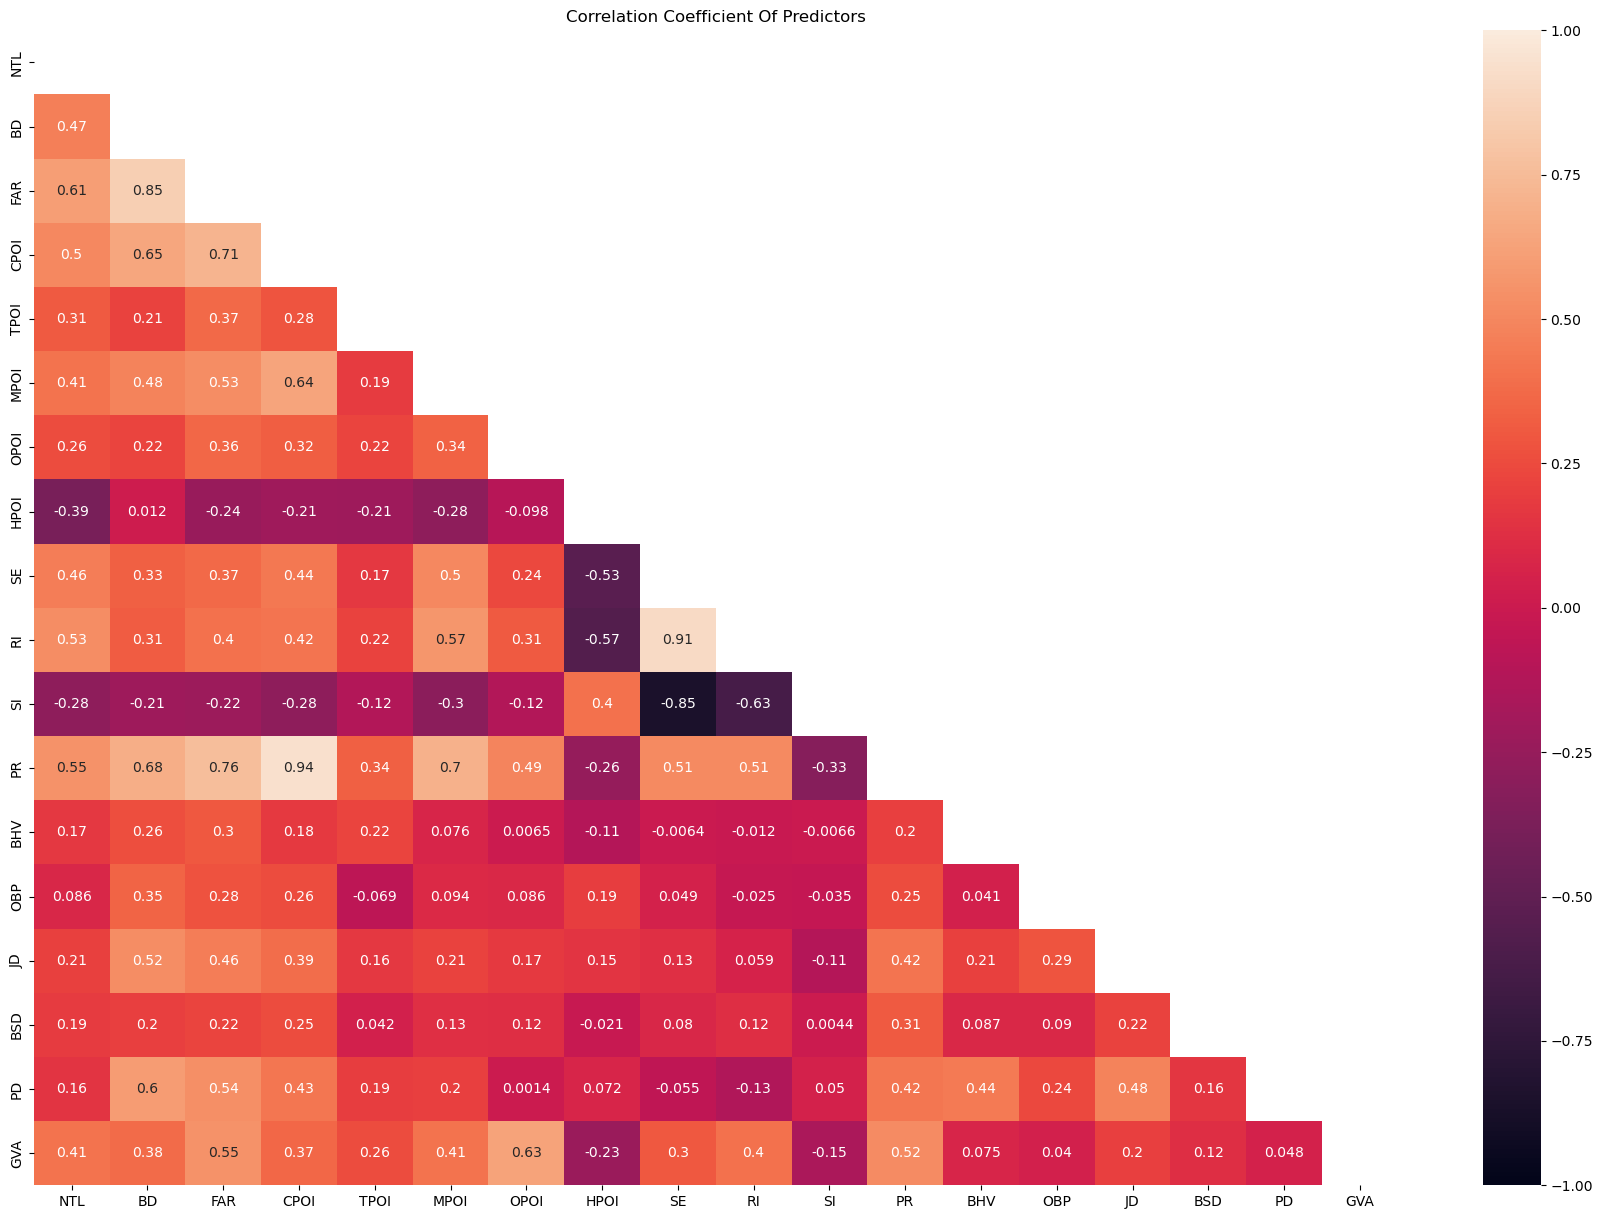

In [32]:
plt.figure(figsize=(22,15))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.savefig('Pearson.jpg')

plt.show()


In [34]:
df_geo.to_csv('Variables.csv')

In [35]:
statistics=df_geo.describe()

In [36]:
statistics.to_excel('statistics.xlsx')

## OLS model

In [37]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('NTL ~ BD + FAR + CPOI + TPOI + MPOI + OPOI + HPOI + SE + RI+ SI+ PR + BHV+ OBP + JD + BSD +  PD + GVA', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns


vif

VIF   variable
0   137.684104  Intercept
1     5.917820         BD
2     7.197612        FAR
3    12.547130       CPOI
4     1.337679       TPOI
5     2.344574       MPOI
6     2.161916       OPOI
7     2.195681       HPOI
8    27.795710         SE
9    14.203907         RI
10    7.232755         SI
11   20.476988         PR
12    1.326921        BHV
13    1.299950        OBP
14    1.637457         JD
15    1.198858        BSD
16    2.699864         PD
17    2.514498        GVA

In [38]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('NTL ~  FAR + CPOI + TPOI + MPOI + OPOI + HPOI + RI+ SI + BHV+ OBP + JD + BSD +  PD + GVA', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns


vif

VIF   variable
0   24.922672  Intercept
1    3.848474        FAR
2    2.784976       CPOI
3    1.263240       TPOI
4    2.195764       MPOI
5    1.754780       OPOI
6    1.750831       HPOI
7    3.331376         RI
8    1.804341         SI
9    1.315424        BHV
10   1.259602        OBP
11   1.601216         JD
12   1.118992        BSD
13   2.346898         PD
14   2.335161        GVA

In [39]:
# Remove variables with high correlation BD, Shannon Entopy, POI ratio

# construct the regression equation
reg_exp = 'NTL ~  FAR + CPOI + TPOI + MPOI + OPOI + HPOI + RI+ SI + BHV + OBP + JD + BSD +  PD + GVA'

# build the OLS regression model:
olsr_model = smf.ols(formula=reg_exp, data=df)

# train the model:
olsr_model_results = olsr_model.fit()

# print out the training summary:
print(olsr_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    NTL   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     51.67
Date:                Sat, 22 Apr 2023   Prob (F-statistic):           3.41e-99
Time:                        20:13:23   Log-Likelihood:                -785.27
No. Observations:                 746   AIC:                             1601.
Df Residuals:                     731   BIC:                             1670.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5871      0.128      4.586      0.0

### Examine the clustering of residuals

In [40]:
olsr_model_results.resid

0      0.122357
1     -0.469934
2     -0.488532
3      0.036926
4     -0.392451
         ...   
741    0.109594
742   -0.145594
743   -0.087954
744    0.108852
745    0.604411
Length: 746, dtype: float64

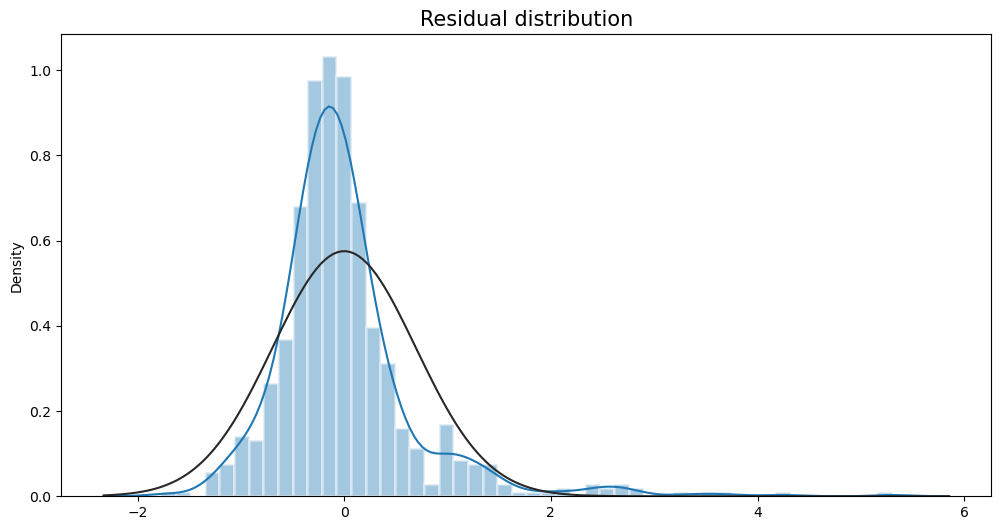

In [41]:
from scipy import stats
fig,ax=plt.subplots(figsize=(12,6))
sns.distplot(olsr_model_results.resid, fit=stats.norm,hist_kws=dict(edgecolor="white", linewidth=2))
ax.set_title('Residual distribution', fontsize=15)
plt.savefig('Residual distribution.jpg')
plt.show()

In [42]:
df_geo['resid']=olsr_model_results.resid

In [43]:
df_geo.isnull().sum()

DataZone      0
geometry      0
NTL           0
Quintilev2    0
BD            0
FAR           0
CPOI          0
TPOI          0
MPOI          0
OPOI          0
HPOI          0
SE            0
RI            0
SI            0
PR            0
BHV           0
OBP           0
JD            0
BSD           0
PD            0
GVA           0
resid         0
dtype: int64

In [44]:
df_geo=df_geo.fillna(0)

In [45]:
df_geo.to_csv('data/residual.csv')

In [46]:
df_geo.to_crs(epsg=3857, inplace=True)

In [47]:
gla_geo.to_crs(epsg=3857, inplace=True)

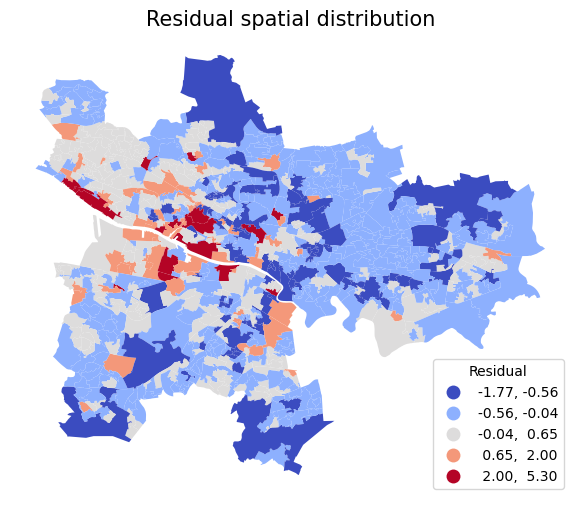

In [48]:
fig,ax=plt.subplots(figsize=(12,6))
df_geo.plot(ax=ax,column='resid', 
                 cmap = 'coolwarm', 
                 figsize=(28,10),
                 scheme='NaturalBreaks',
                 k=5, 
                 legend = True, 
                 legend_kwds = {'title':'Residual','loc':'lower right'})
ax.set_title('Residual spatial distribution', fontsize=15)


ax.set_axis_off()

In [49]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(df_geo, k=8)
# Row-standardization
w.transform = "R"

#compute the spatial lag of rediduals
df_geo["resid"] = weights.spatial_lag.lag_spatial(w, df_geo["resid"])

moran_resid = esda.moran.Moran(df_geo["resid"], w)

moran_resid.p_sim

0.001

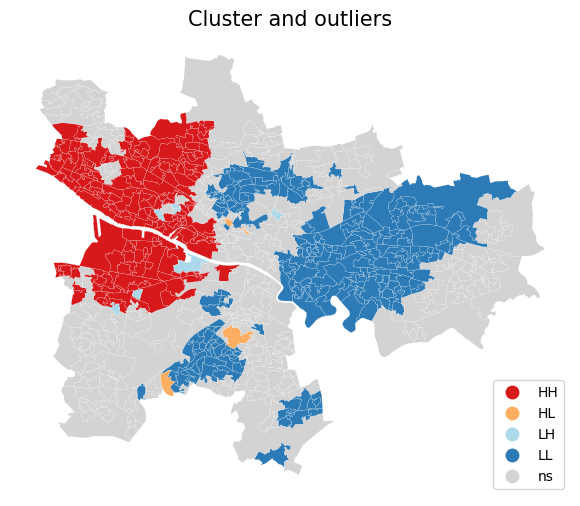

In [50]:
lisa = esda.moran.Moran_Local(df_geo["resid"], w,permutations=9999)
from splot import esda as esdaplot

# Set up figure and axes
fig,ax=plt.subplots(figsize=(12,6))
# Plot Quandrant colors In this case, we use a 5% significance
esdaplot.lisa_cluster(lisa, df_geo, p=0.05, ax=ax,legend = True, 
                 legend_kwds = {'loc':'lower right'})

ax.set_title('Cluster and outliers', fontsize=15)
ax.set_axis_off()
# Display the figure

plt.show()


## GWR model

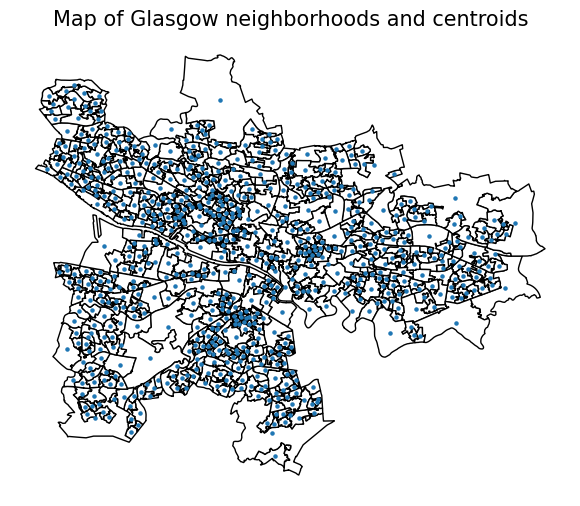

In [51]:
#GWR regression
fig, ax = plt.subplots(figsize=(12, 6))
gla_geo.plot(color = 'white', edgecolor = 'black', ax = ax)
gla_geo.centroid.plot(ax=ax,markersize=5)
ax.set_title('Map of Glasgow neighborhoods and centroids', fontsize=15)
ax.axis("off")
plt.show()

In [52]:
y = df_geo['NTL'].values.reshape((-1,1)) # reshape is needed to have column array
y.shape

(746, 1)

In [53]:
X = df_geo[['FAR',
            'CPOI','TPOI','MPOI','OPOI','HPOI',
            'RI','SI','BHV','OBP',
            'JD','BSD',
            'PD','GVA']].values
X.shape

(746, 14)

In [54]:
df_geo['X'] = df_geo.geometry.centroid.x
df_geo['Y'] = df_geo.geometry.centroid.y

In [55]:
df_geo.isnull().values.any()

False

In [56]:
df_geo=df_geo.fillna(0)

In [57]:
u = df_geo['X']
v = df_geo['Y']
coords = list(zip(u,v))

In [58]:
X = (X - X.mean(axis=0)) / X.std(axis=0)

y = y.reshape((-1,1))

y = (y - y.mean(axis=0)) / y.std(axis=0)

In [59]:
%%time
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

CPU times: user 4.55 s, sys: 6.4 s, total: 10.9 s
Wall time: 2.49 s


In [60]:
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 237.0


In [61]:
gwr_results = GWR(coords, y, X, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 746
Number of covariates:                                                    15

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            374.948
Log-likelihood:                                                    -801.927
AIC:                                                               1633.854
AICc:                                                              1636.600
BIC:                                                              -4460.417
R2:                                                                   0.497
Adj. R2:                                                              0.488

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [69]:
from sklearn.metrics import mean_squared_error, r2_score

print('RMSE=',np.sqrt(mean_squared_error(y, gwr_results.predy)))


RMSE= 0.5663546806014186


## MGWR model

In [62]:
#Calibrate MGWR model
mgwr_selector = Sel_BW(coords, y, X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(coords, y, X, mgwr_selector).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[142. 150. 744. 270. 744. 742.  20. 628. 744.  67. 742. 744. 346. 744.
 734.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [63]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 746
Number of covariates:                                                    15

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            374.948
Log-likelihood:                                                    -801.927
AIC:                                                               1633.854
AICc:                                                              1636.600
BIC:                                                              -4460.417
R2:                                                                   0.497
Adj. R2:                                                              0.488

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [70]:
print('RMSE=',np.sqrt(mean_squared_error(y, mgwr_results.predy)))

RMSE= 0.4619157317872804


## XGBoost model

In [75]:
#XGBoost with coords of X and Y
#import dataset
y = df_geo['NTL']
X_coords = df_geo.drop(['NTL','DataZone','geometry','Quintilev2','resid'], axis=1)

In [76]:
X_coords.columns

Index(['BD', 'FAR', 'CPOI', 'TPOI', 'MPOI', 'OPOI', 'HPOI', 'SE', 'RI', 'SI',
       'PR', 'BHV', 'OBP', 'JD', 'BSD', 'PD', 'GVA', 'X', 'Y'],
      dtype='object')

In [65]:
from sklearn.metrics import mean_squared_error, r2_score

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_coords, y, 
                                                    test_size = 0.2,
                                                    random_state = 1018)

### Tune hyperparameters with a Bayesian optimisation package

In [67]:
%%time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 30, 1, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.3, 1.01, 0.05),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 30, 1, dtype=int)),
        'subsample':        hp.quniform('subsample', 0.3, 1.01, 0.05),
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 1.01, 0.05)),
        'gamma': hp.quniform('gamma', 0.1, 5, 0.05),
    
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
    }

def score(params, n_folds=5):
    
    #Cross-validation
    d_train = xgb.DMatrix(X_coords,y) # Convert the input data to XGBoost's DMatrix format
    
    cv_results = xgb.cv(params, d_train, nfold = n_folds, num_boost_round=500,
                        early_stopping_rounds = 10, metrics = 'rmse', seed = 0) 
                        # Perform cross-validation using the input parameters
    
    loss = min(cv_results['test-rmse-mean']) # Calculate the minimum RMSE obtained during cross-validation
    
    return loss


def optimize(trials, space):
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=2000,
                rstate=np.random.default_rng(333))
                # Use Tree-structured Parzen Estimator (TPE) algorithm for optimization
    return best

CPU times: user 44.1 ms, sys: 26.3 ms, total: 70.4 ms
Wall time: 154 ms


In [68]:
trials = Trials()
best_params = optimize(trials, space) # Obtain the best hyperparameters by optimizing the score function

# Return the best parameters
best_params = space_eval(space, best_params) # Evaluate the best hyperparameters in the hyperparameter space

best_params

100%|███| 2000/2000 [4:49:34<00:00,  8.69s/trial, best loss: 0.6247908988845069]


{'colsample_bytree': 0.8500000000000001,
 'eval_metric': 'rmse',
 'gamma': 0.2,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 0.6000000000000001}

In [69]:
data_test = xgb.DMatrix(X_test,y_test)

data = xgb.DMatrix(X_train,y_train)
final_model = xgb.train(best_params, data, num_boost_round=500, verbose_eval=False,
                            evals=[(data_test, "Test")],early_stopping_rounds=10)
#                           用于monitor训练过程中的模型表现

data_all = xgb.DMatrix(X_coords)
y_pred = final_model.predict(data_all)
print(np.sqrt(mean_squared_error(y, y_pred)))
print(r2_score(y, y_pred))

print(np.mean(y_pred))

0.40899514504671924
0.8250843259539288
1.2893616


## SHAP analysis of xgboost results

In [72]:
explainer = shap.TreeExplainer(final_model)

shap_values = explainer(X_coords)

shap_values_scatter = explainer.shap_values(X_coords)

In [73]:
# Get the interaction SHAP value
shap_interaction = explainer.shap_interaction_values(X_coords)

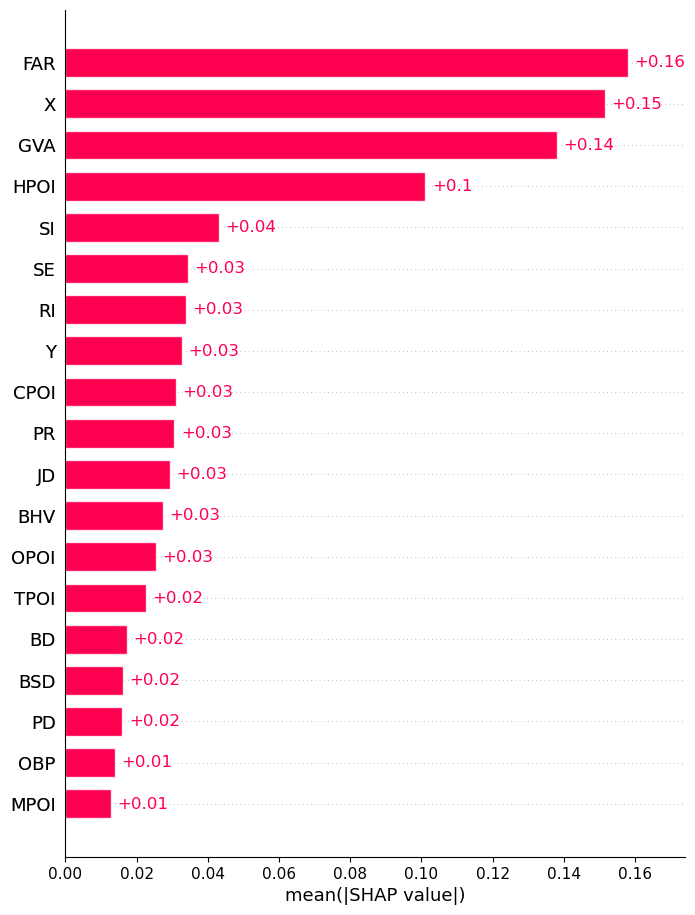

In [74]:
#Mean SHAP
shap.plots.bar(shap_values,max_display=20)


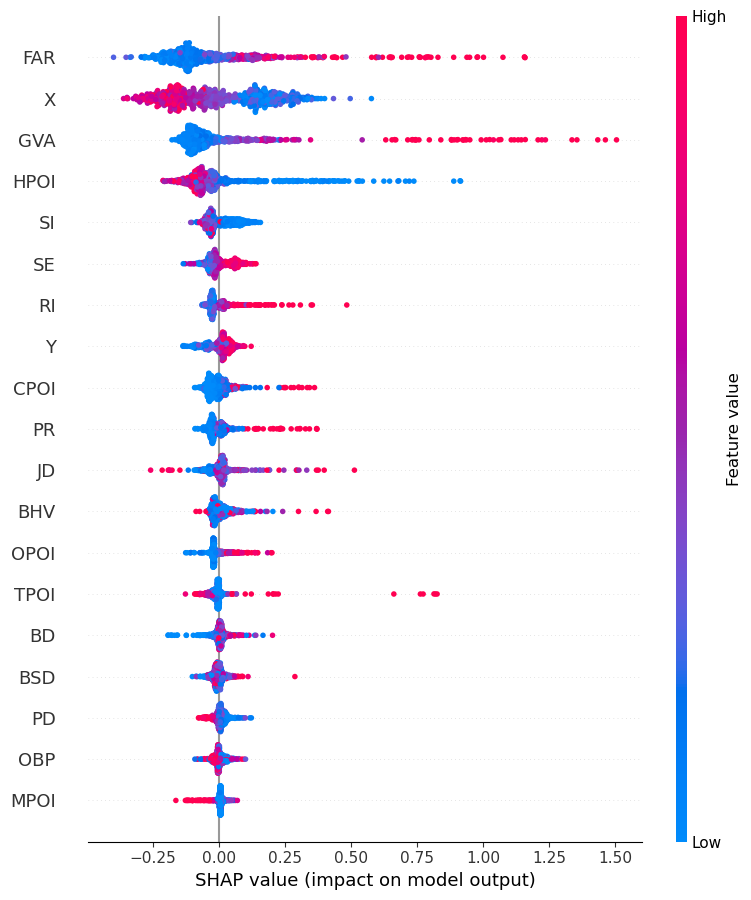

In [75]:
# Display beeswarm plot
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, max_display=20)

In [76]:
shapvaluerank = ['FAR','X','GVA','HPOI','SI','SE','RI','Y','CPOI',
                 'PR','JD','BHV','OPOI','TPOI','BD','BSD','PD','OBP','MPOI']  


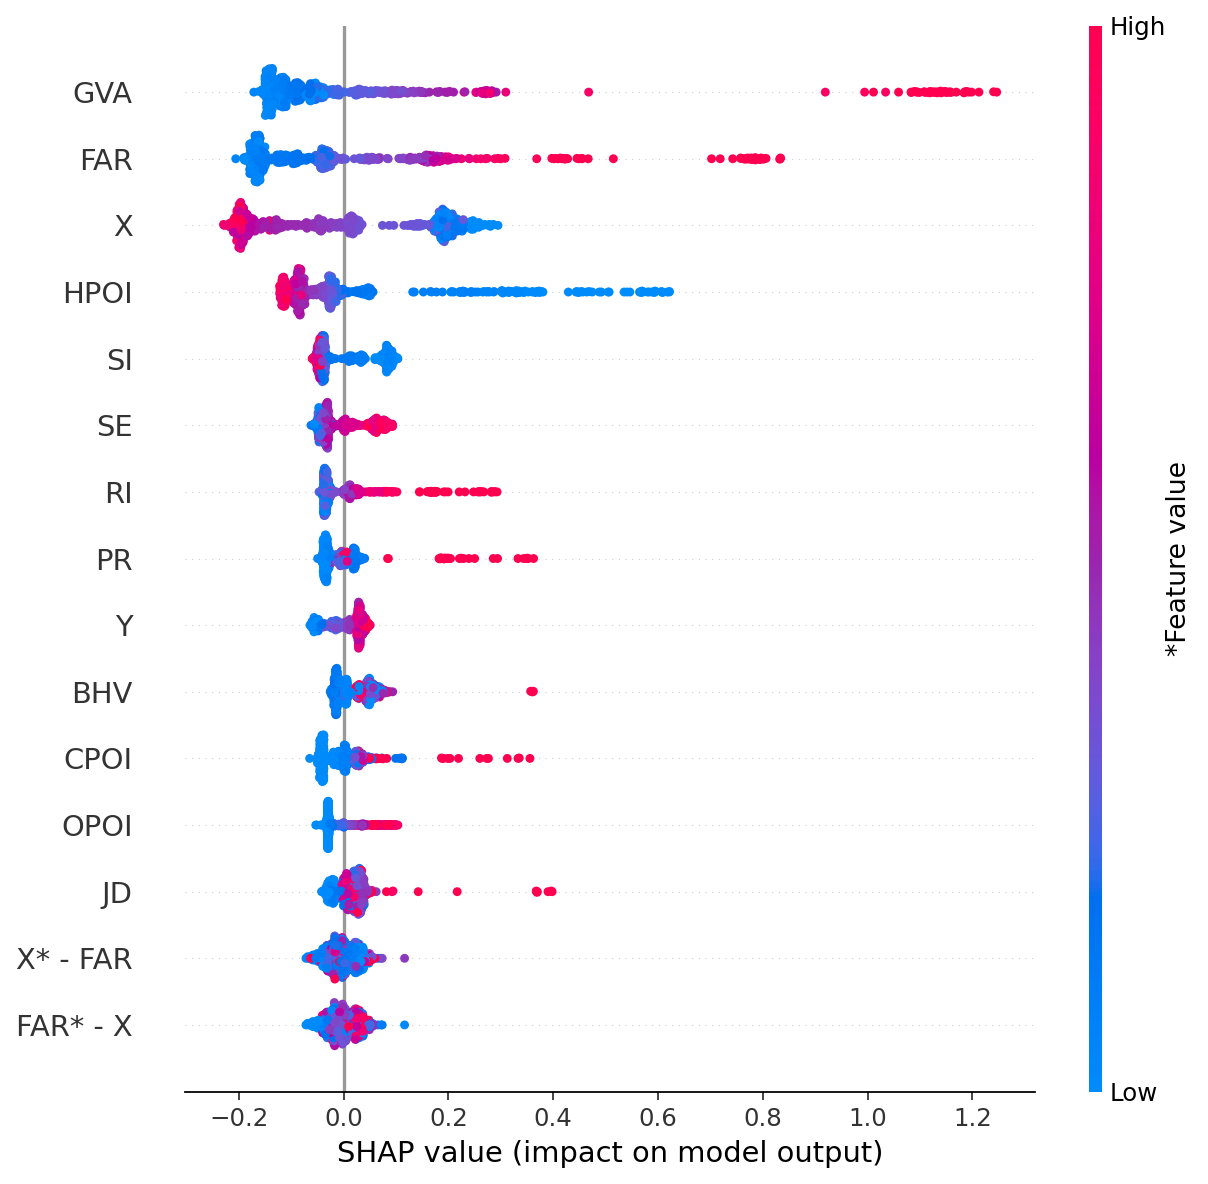

Text(0.5, 1.0, 'Figure 3: Spatial distribution of propotion of \nneighborhood mental disorders prevalence (NMDP) in Glasgow')

In [77]:
fig, ax = plt.subplots(figsize=(8, 6),dpi=160)

shap.summary_plot(shap_interaction, X_coords, max_display=15,
                  plot_type="compact_dot")

ax.set_title('Figure 3: Spatial distribution of propotion of \nneighborhood mental disorders prevalence (NMDP) in Glasgow',fontsize=15)


In [326]:
df_geo.columns

Index(['DataZone', 'geometry', 'NTL', 'Quintilev2', 'BD', 'FAR', 'CPOI',
       'TPOI', 'MPOI', 'OPOI', 'HPOI', 'SE', 'RI', 'SI', 'PR', 'BHV', 'OBP',
       'JD', 'BSD', 'PD', 'GVA', 'resid', 'X', 'Y'],
      dtype='object')

In [327]:
X_coords

BD       FAR       CPOI       TPOI       MPOI         OPOI  \
0    0.194114  0.479066   0.000000   0.000000   0.000000     0.000000   
1    0.125103  0.646000   0.000000  22.043990   0.000000     0.000000   
2    0.243887  0.871436  15.044603   0.000000  24.071363  3935.668212   
3    0.139742  0.318583   6.407052   6.407052   6.407052     0.000000   
4    0.115418  0.576168  19.902101   6.634034   0.000000  1167.589949   
..        ...       ...        ...        ...        ...          ...   
741  0.147014  0.598970  61.239087   8.165212   0.000000  3225.258591   
742  0.109949  0.392381   9.161577   9.161577   0.000000     0.000000   
743  0.113939  0.383483   4.276606   8.553212   0.000000     0.000000   
744  0.070313  0.000000   0.000000   0.000000   4.142086     0.000000   
745  0.141963  0.000000  29.345797   4.890967   0.000000     0.000000   

            HPOI    SE    RI    SI        PR        BHV   OBP          JD  \
0    2675.490494  1.00   2.0  0.50  0.254809  32.097893  0.00  101.923447   
1     595.187728  2.53   7.0  0.23  1.469599  77.294066  0.00   44.087980   
2     565.677022  5.06  22.0  0.04  2.166423  34.120655  0.53   96.285451   
3    2204.025979  2.52   6.0  0.18  0.512564  10.343465  0.00   64.070523   
4     563.892873  3.68  11.0  0.09  1.326807  69.484806  0.01  119.412608   
..           ...   ...   ...   ...       ...        ...   ...         ...   
741   498.077909  4.97  17.0  0.04  3.102780  12.254673  0.07   77.569510   
742  1218.489717  3.08  11.0  0.15  1.282621  20.967277  0.00   87.034980   
743  1586.620747  2.61   7.0  0.21  0.812555  31.429205  0.01   98.361933   
744  1023.095349  2.25   5.0  0.22  0.331367   0.000000  0.00   91.125901   
745   523.333438  3.80  12.0  0.09  1.662929   0.000000  0.04   83.146434   

           BSD           PD         GVA              X             Y  
0     0.000000  7427.671229   54.809522 -481769.142095  7.518469e+06  
1    51.435977  6620.544980   43.873771 -482058.780289  7.520566e+06  
2    24.071365  2536.519839  193.885096 -481666.917895  7.519367e+06  
3    12.814105  5042.350132   10.615452 -482263.746360  7.518910e+06  
4    19.902101  8803.362856   29.900300 -482335.485657  7.519845e+06  
..         ...          ...         ...            ...           ...  
741  40.826058  3421.223670  170.933000 -486716.972627  7.540776e+06  
742  22.903942  4466.268699   10.324945 -487840.697681  7.540476e+06  
743  25.659634  4794.075088    2.209042 -487708.003488  7.541022e+06  
744   8.284173  3263.964108    7.841930 -487992.320868  7.541548e+06  
745  29.345797  3135.109662   16.652303 -487568.675400  7.539971e+06  

[746 rows x 19 columns]

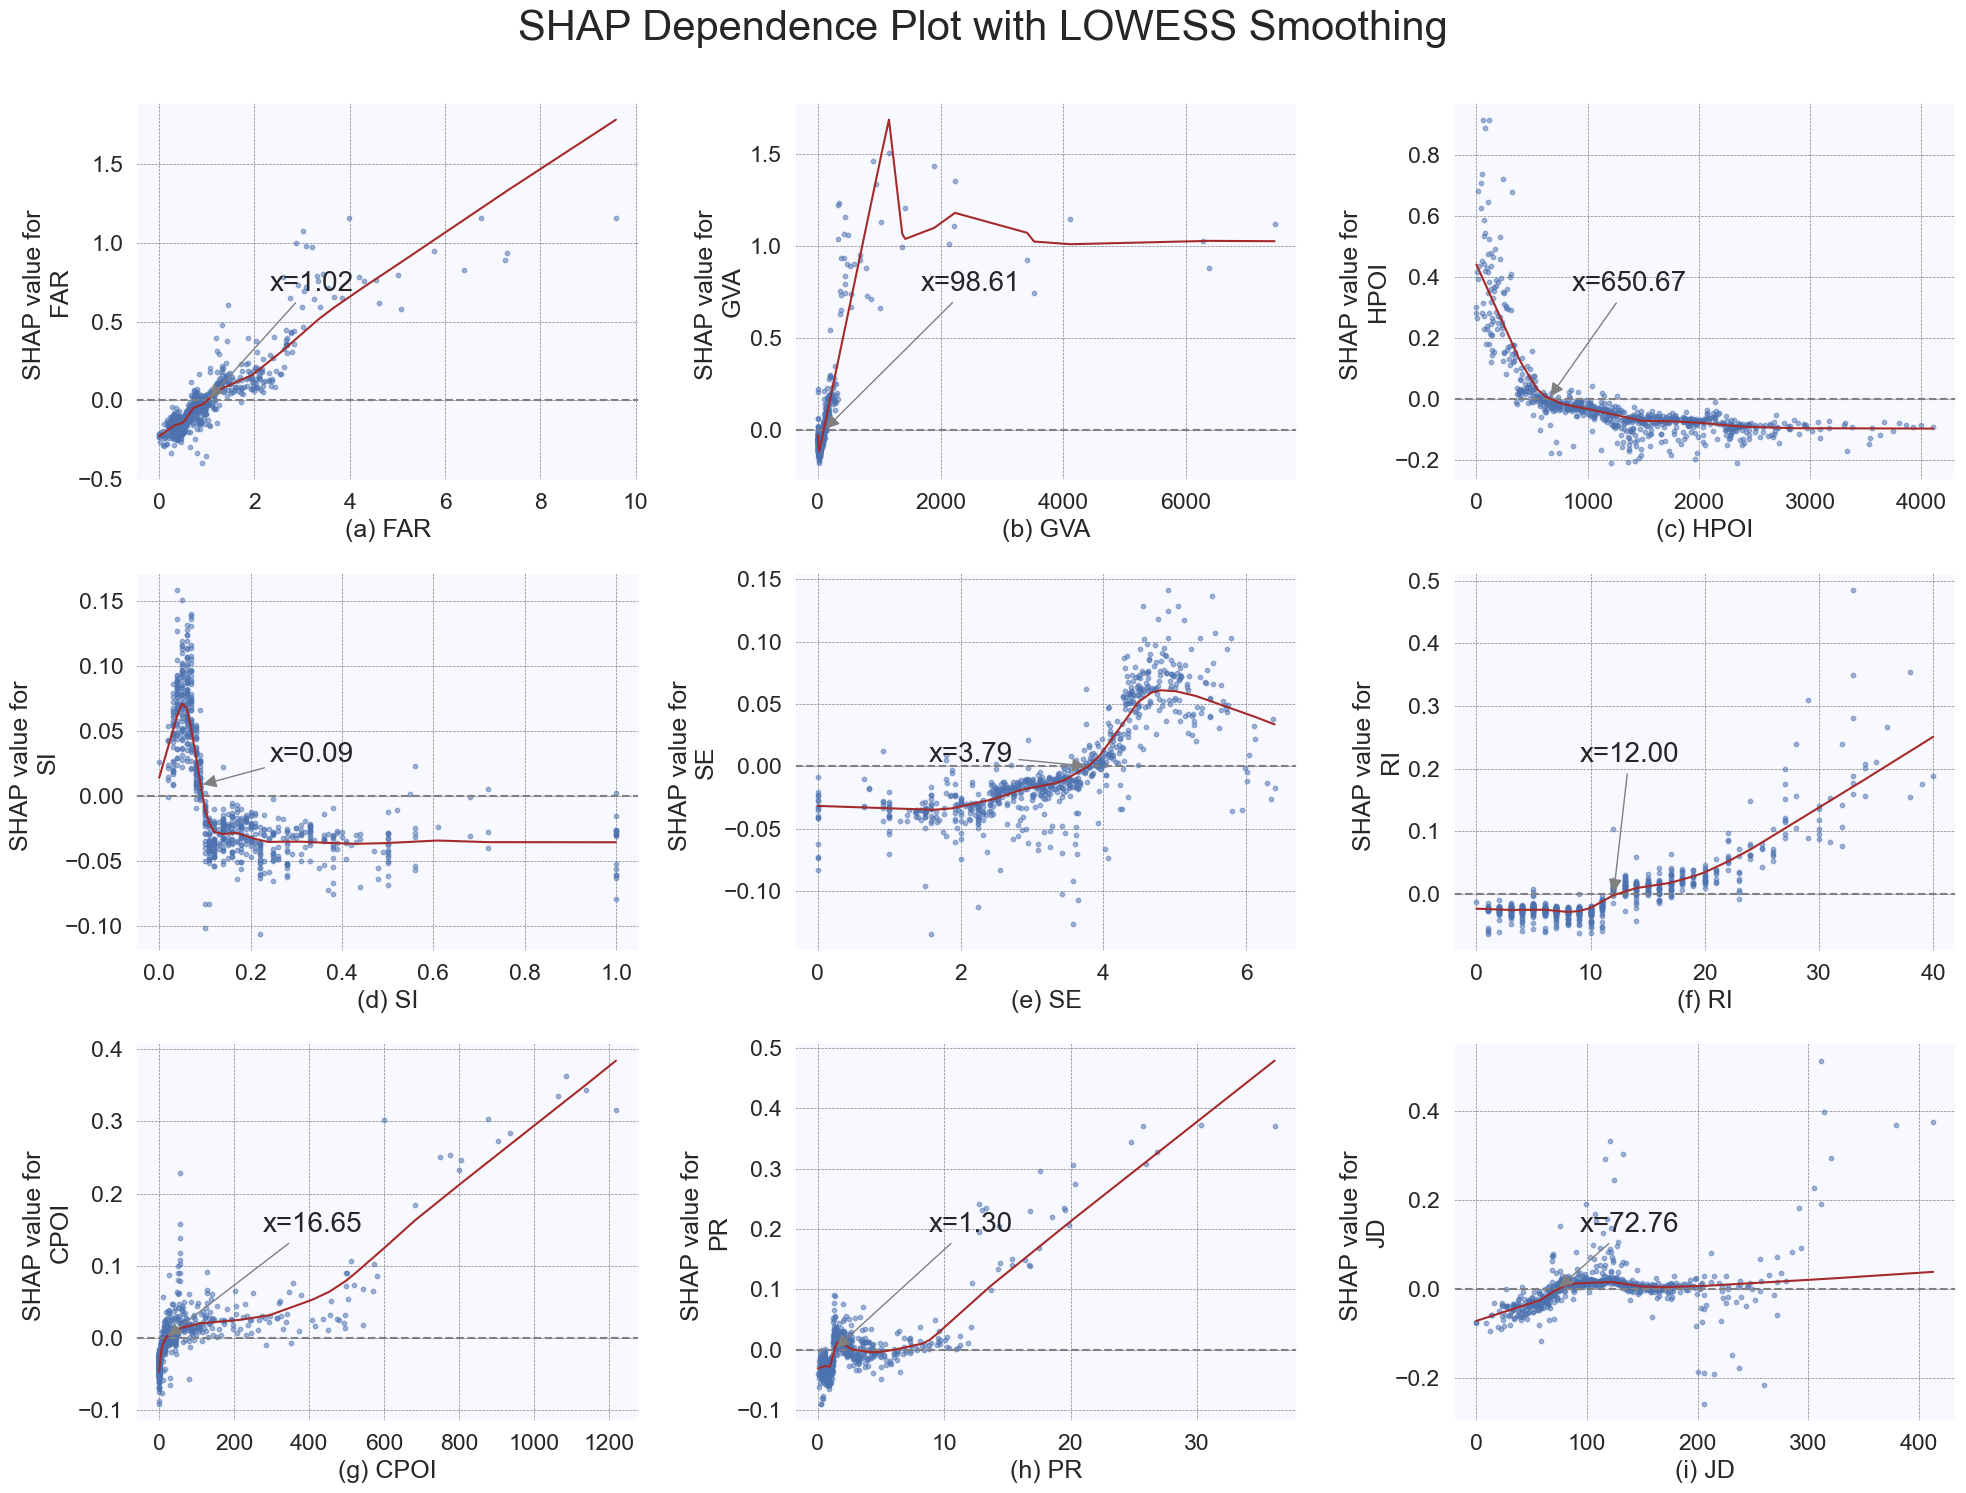

<Figure size 640x480 with 0 Axes>

In [465]:
li_var=[1,16,6,9,7,8,2,10,13]
shapvaluerank = ['FAR','GVA','HPOI','SI','SE','RI','CPOI','PR','JD']
abc=['a','b','c','d','e','f','g','h','i']
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 15)) # Creates 3 rows and 3 columns of subplots
fig.suptitle('SHAP Dependence Plot with LOWESS Smoothing', fontsize=30, y=1)
axs = axs.flatten()  # Flatten the axs array for easier indexing

# Loop through each subplot
for i,var, ax in zip(abc,shapvaluerank, axs):
    # Extract SHAP values for the feature of interest
    x = X_coords.columns.get_loc(var)
    shap_values_feature = shap_values_scatter[:, x]

    # Sort your data by the values of the feature of interest
    sorted_idx = np.argsort(X_coords[var].values)
    X_sorted = X_coords.iloc[sorted_idx]
    shap_values_sorted = shap_values_feature[sorted_idx]

    # Plot scatter plot on the current subplot
    ax.scatter(X_coords[var], shap_values_scatter[:, x], alpha=0.5, s=10)

    # Plot LOWESS line on the current subplot
    lowess = sm.nonparametric.lowess(shap_values_sorted, X_sorted[var], frac=0.3) 
    ax.axhline(y=0, color='grey', linestyle='--')
    ax.plot(lowess[:, 0], lowess[:, 1], color='brown', linewidth=1.5)
    ax.set_facecolor("ghostwhite")
    ax.set_ylabel('SHAP value for \n{}'.format(var))
    ax.set_xlabel('({}) {}'.format(i,var))
    
    # Add grid to the plot
    ax.grid(True, color='grey', linestyle='--', linewidth=0.5)

    # Add annotation for x value where the LOWESS line approaches y=0
    x_annotate = lowess[:, 0][np.argmin(np.abs(lowess[:, 1]))]  # x value where y value of LOWESS line is closest to 0
    y_annotate = lowess[:, 1][np.argmin(np.abs(lowess[:, 1]))]  # y value of LOWESS line at x_annotate
    ax.annotate('x={:.2f}'.format(x_annotate), xy=(x_annotate, y_annotate), xytext=(0.35,0.5),textcoords='axes fraction',
                arrowprops=dict(arrowstyle='-|>', color='grey'), ha='center', fontsize=20)



 # Show the plots
plt.tight_layout()
plt.show()
plt.savefig('SHAP Dependence Plot with LOWESS Smoothing.jpg')



In [85]:
#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

print(mean_pred, sum_shap)


Model prediction: 1.5320260524749756
Mean prediction + interaction values: 0.7699703574180603
1.298461 -0.5284906


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0, 0.5, 'BD'),
  Text(0, 1.5, 'FAR'),
  Text(0, 2.5, 'CPOI'),
  Text(0, 3.5, 'TPOI'),
  Text(0, 4.5, 'MPOI'),
  Text(0, 5.5, 'OPOI'),
  Text(0, 6.5, 'HPOI'),
  Text(0, 7.5, 'SE'),
  Text(0, 8.5, 'RI'),
  Text(0, 9.5, 'SI'),
  Text(0, 10.5, 'PR'),
  Text(0, 11.5, 'BHV'),
  Text(0, 12.5, 'OBP'),
  Text(0, 13.5, 'JD'),
  Text(0, 14.5, 'BSD'),
  Text(0, 15.5, 'PD'),
  Text(0, 16.5, 'GVA'),
  Text(0, 17.5, 'X'),
  Text(0, 18.5, 'Y')])

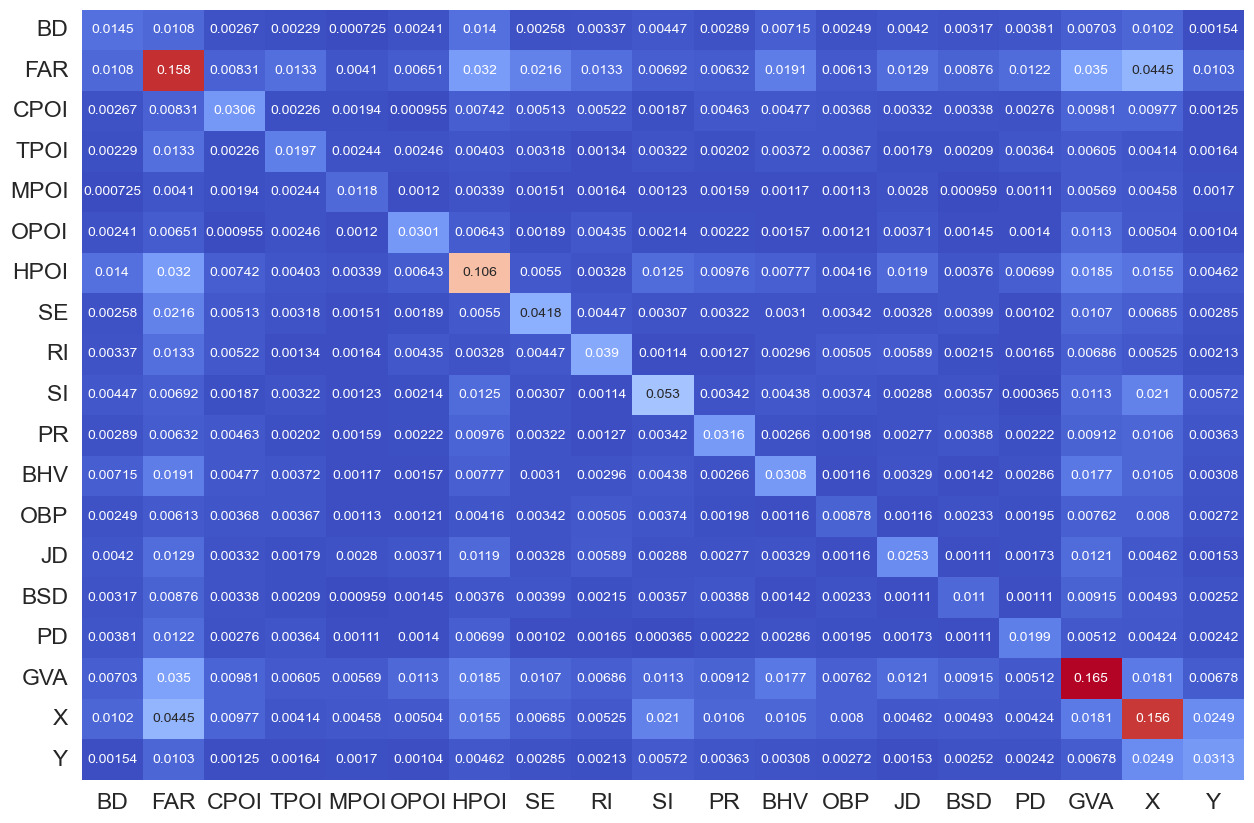

In [86]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X_coords.columns,columns=X_coords.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
plt.figure(figsize=(15, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False,annot_kws={"size": 10})
plt.yticks(rotation=0) 

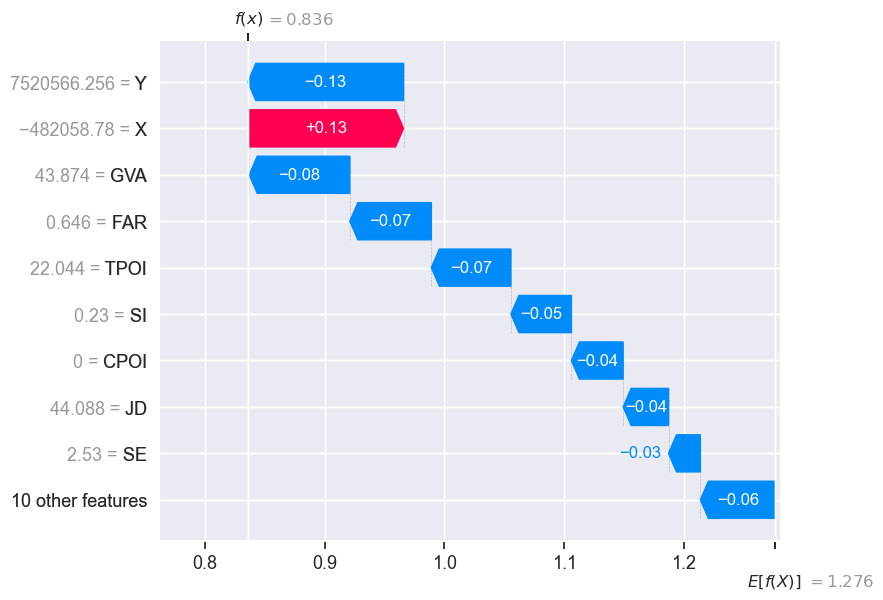

In [87]:
shap.plots.waterfall(shap_values[1])

In [272]:
df_geo['Quintilev2']=df_geo['Quintilev2'].astype('int')

### Distribution of urban vitality proxy among neighbourhoods

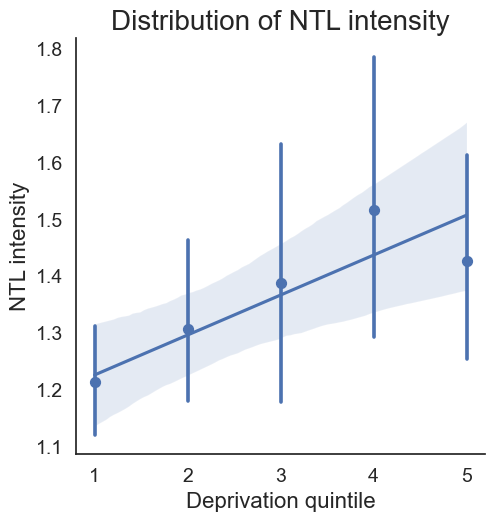

In [507]:
sns.set_style("white")
ax=sns.lmplot(x="Quintilev2", y="NTL", data=df_geo, x_estimator=np.mean).set(title="Monthly Avg Temperatures")

ax.fig.set_dpi(100)
plt.xlabel('Deprivation quintile', fontsize=16);
plt.ylabel('NTL intensity', fontsize=16);
plt.title('Distribution of NTL intensity', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)


### SHAP value of most deprived neighbourhoods

In [241]:
df_geo.sort_values('NTL',ascending=True).head(20)

DataZone                                           geometry       NTL  \
258  S01010016  POLYGON ((-471515.921 7523809.161, -471252.746...  0.594728   
448  S01010206  POLYGON ((-468259.249 7534409.834, -468355.690...  0.597316   
306  S01010064  POLYGON ((-465344.532 7527496.059, -465296.302...  0.597439   
242  S01010000  POLYGON ((-471971.751 7523669.714, -471858.691...  0.598609   
485  S01010243  POLYGON ((-467902.552 7531083.422, -467890.792...  0.598763   
233  S01009991  POLYGON ((-470398.296 7521172.065, -470380.868...  0.600884   
227  S01009985  POLYGON ((-469592.296 7520291.940, -469586.230...  0.602563   
355  S01010113  POLYGON ((-459226.493 7533407.711, -459148.190...  0.603788   
18   S01009776  POLYGON ((-485749.415 7521887.337, -485683.107...  0.604671   
370  S01010128  POLYGON ((-461073.013 7530911.491, -461068.946...  0.604737   
365  S01010123  POLYGON ((-459487.147 7529841.060, -459605.090...  0.607338   
423  S01010181  POLYGON ((-465974.504 7534538.108, -465973.147...  0.608070   
551  S01010309  POLYGON ((-474251.308 7534754.739, -474235.552...  0.610029   
586  S01010344  POLYGON ((-473194.167 7539057.445, -473281.481...  0.612403   
141  S01009899  POLYGON ((-475581.300 7523446.722, -475445.876...  0.612522   
484  S01010242  POLYGON ((-468652.974 7531143.148, -468614.964...  0.612870   
22   S01009780  POLYGON ((-483123.426 7522108.529, -483059.321...  0.613053   
19   S01009777  POLYGON ((-484218.485 7522016.147, -484098.781...  0.614217   
553  S01010311  POLYGON ((-473725.895 7535367.828, -473660.551...  0.615167   
409  S01010167  POLYGON ((-462388.138 7534420.774, -462286.210...  0.616230   

    Quintilev2        BD       FAR        CPOI       TPOI       MPOI  \
258          2  0.170712  0.539116    0.000000   9.391897   0.000000   
448          3  0.000000  0.000000    0.000000   0.000000   0.000000   
306          2  0.130419  0.582052   20.750307   0.000000  10.375153   
242          3  0.190929  0.618389    0.000000   0.000000   0.000000   
485          1  0.317567  1.550613  274.140784   0.000000   0.000000   
233          3  0.203039  0.650740    0.000000   0.000000   0.000000   
227          1  0.103900  0.426800    0.000000   9.639425   0.000000   
355          1  0.201615  0.825790   14.882983   0.000000   0.000000   
18           1  0.081211  0.269880    0.000000   0.000000   0.000000   
370          1  0.164913  0.973151    0.000000  46.301822   0.000000   
365          1  0.134260  0.554128    9.609317   0.000000   0.000000   
423          1  0.137928  0.525624    8.671732   0.000000   0.000000   
551          1  0.061253  0.212013    0.000000   9.759503   0.000000   
586          1  0.042052  0.111248    3.712995   3.712995   3.712995   
141          3  0.267627  1.512565   41.323075   0.000000   0.000000   
484          1  0.197145  1.127096   48.031787   0.000000   0.000000   
22           1  0.179247  0.568869   11.323599  11.323599   0.000000   
19           1  0.098671  0.356473    0.000000   0.000000   0.000000   
553          1  0.102251  0.513193   96.190768   0.000000  10.687863   
409          1  0.126194  0.386971    0.000000   5.912111   5.912111   

            OPOI  ...        PR         BHV   OBP          JD        BSD  \
258     0.000000  ...  0.469595   66.193213  0.38  103.310868   9.391897   
448     0.000000  ...  0.000000  273.113487  0.00    0.000000   0.000000   
306  1483.646936  ...  1.141267   69.709800  0.31   93.376381  10.375153   
242     0.000000  ...  1.085007   42.172234  0.92   15.500094  62.000374   
485     0.000000  ...  4.485940  216.215762  1.00   99.687558   0.000000   
233  3935.231663  ...  1.188892   65.673086  0.85   47.555669  59.444587   
227  1243.485855  ...  0.963943   41.252268  0.00   86.754827   9.639425   
355     0.000000  ...  1.934788   50.707962  0.02   59.531931  74.414914   
18      0.000000  ...  0.355748   13.988112  0.18   26.681096  17.787397   
370     0.000000  ...  0.694527  231.409477  0.00  115.754555  23.150911 

In [281]:
df_geo.loc[[485,227,355,18,370],'DataZone']

485    S01010243
227    S01009985
355    S01010113
18     S01009776
370    S01010128
Name: DataZone, dtype: object

In [514]:

shap.plots.force(shap_values[485])

In [242]:

shap.plots.force(shap_values[227])

In [275]:

shap.plots.force(shap_values[355])

In [511]:

shap.plots.force(shap_values[18])


In [277]:

shap.plots.force(shap_values[370])

In [283]:

shap.plots.force(shap_values[423])

In [90]:
shap.plots.force(shap_values[0:100])

### Interaction SHAP value

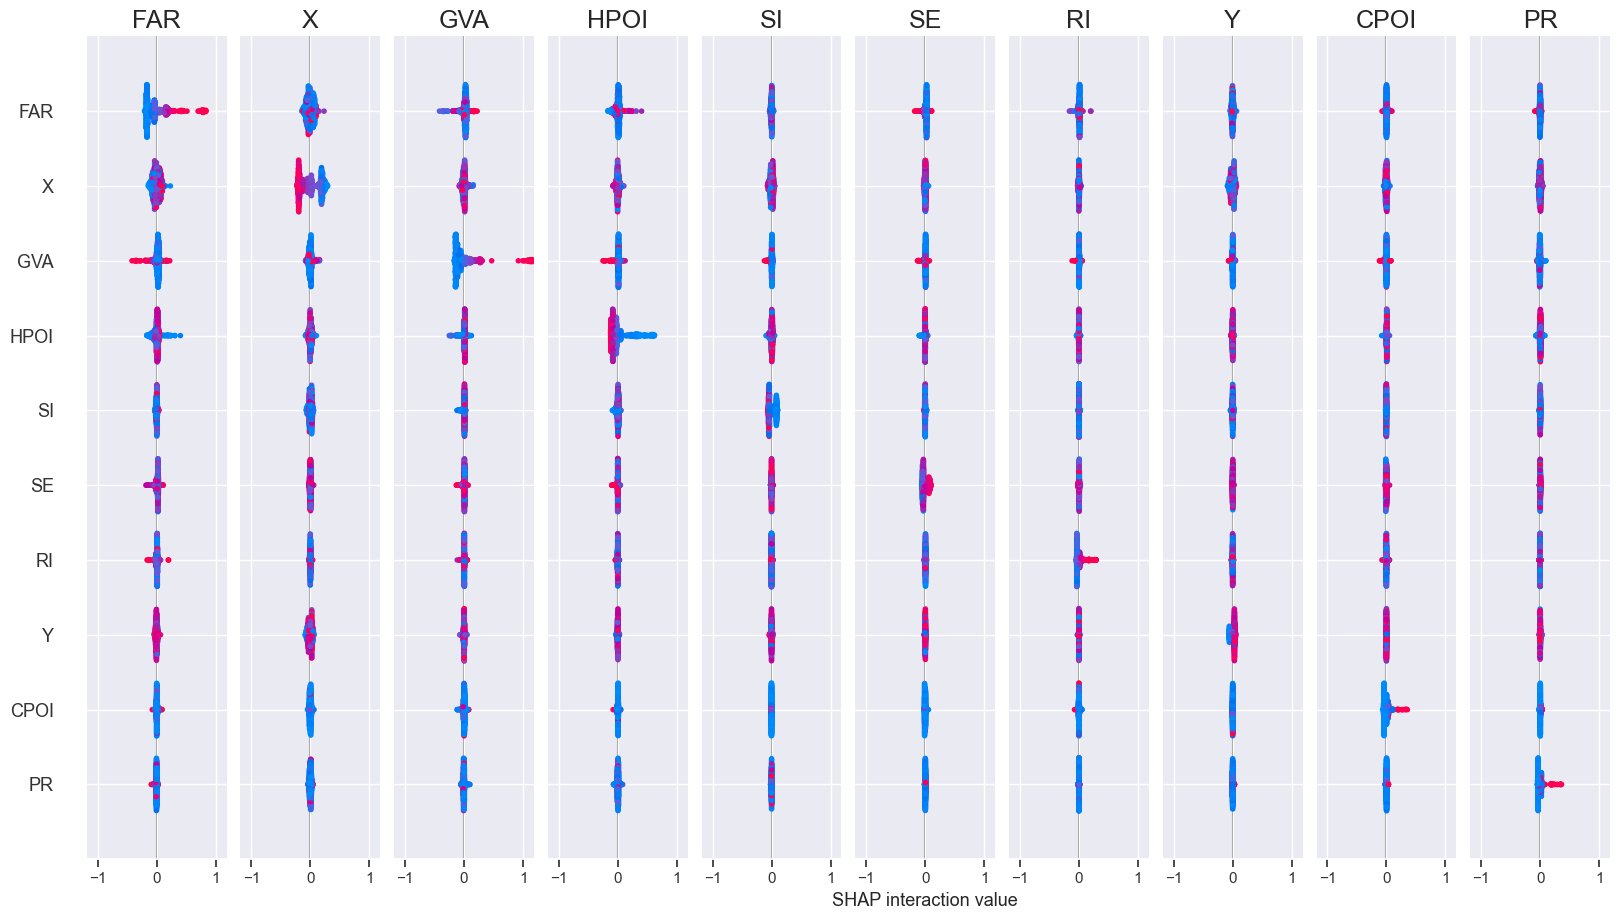

In [143]:
#Display interaction summary plot
shap.summary_plot(shap_interaction, X_coords,max_display=10)

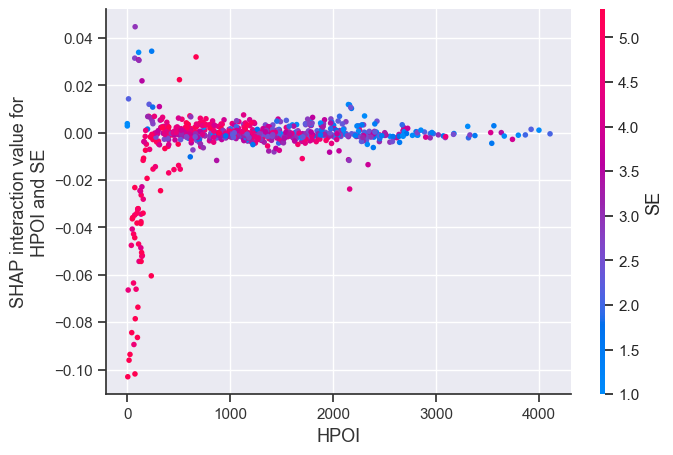

In [102]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("HPOI","SE"),
    shap_interaction, X_coords,
    display_features=X_coords)

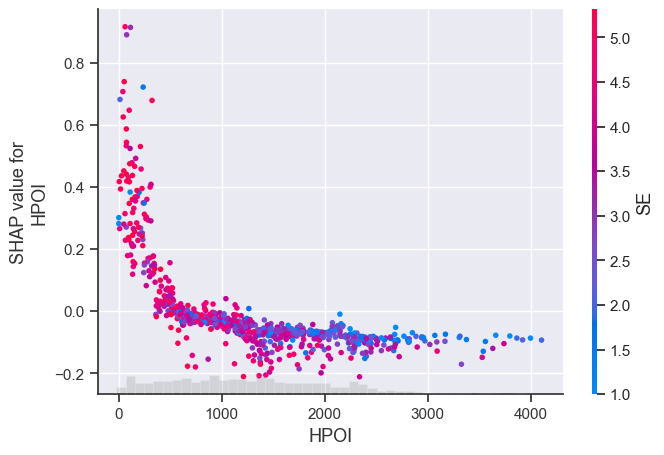

In [103]:
shap.plots.scatter(shap_values[:,"HPOI"],
                   color=shap_values[:,"SE"])

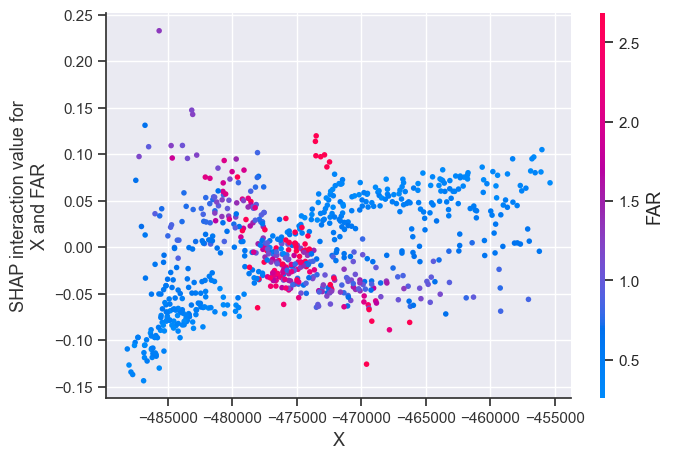

In [107]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("X", "FAR"),
    shap_interaction, X_coords,
    display_features=X_coords)

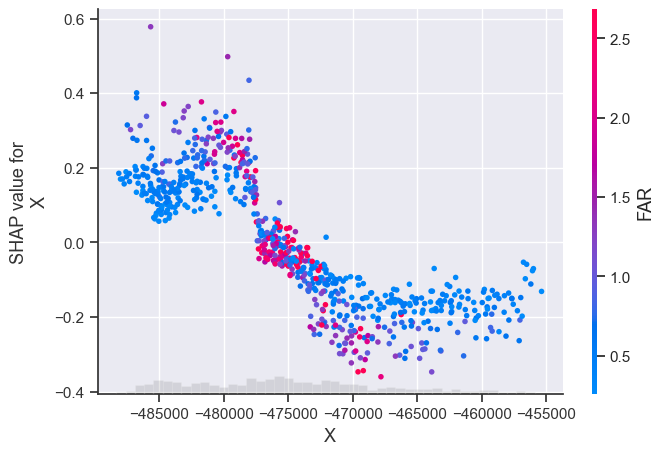

In [108]:
shap.plots.scatter(shap_values[:,"X"],
                   color=shap_values[:,"FAR"])

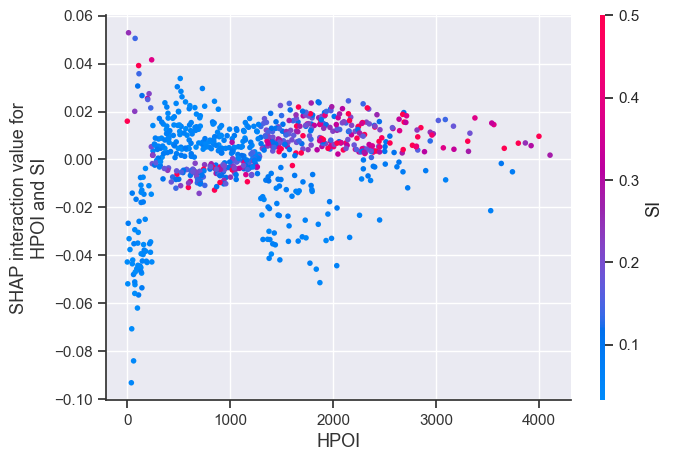

In [150]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("HPOI", "SI"),
    shap_interaction, X_coords,
    display_features=X_coords)

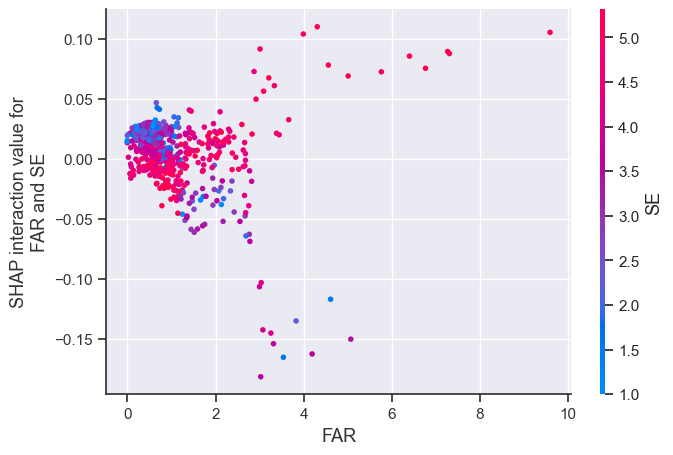

In [151]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("FAR","SE"),
    shap_interaction, X_coords,
    display_features=X_coords)

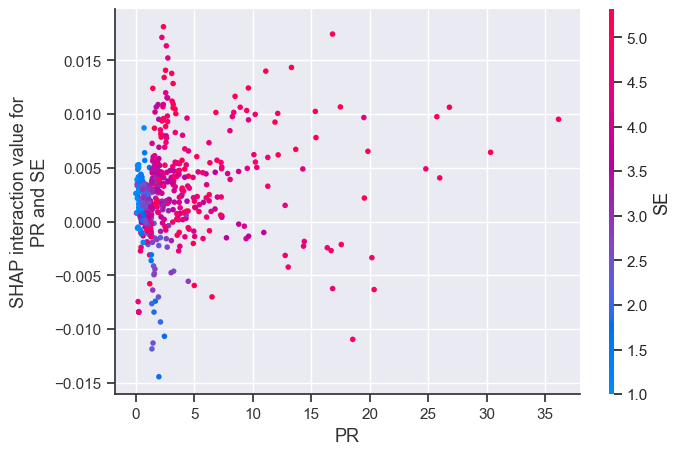

In [230]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("PR","SE"),
    shap_interaction, X_coords,
    display_features=X_coords)

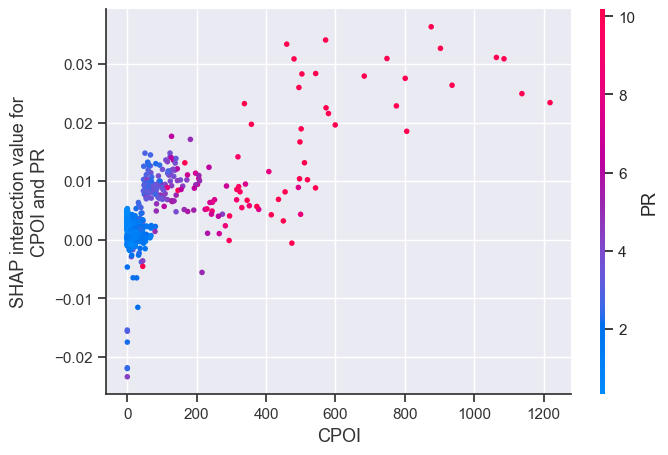

In [207]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("CPOI","PR"),
    shap_interaction, X_coords,
    display_features=X_coords)

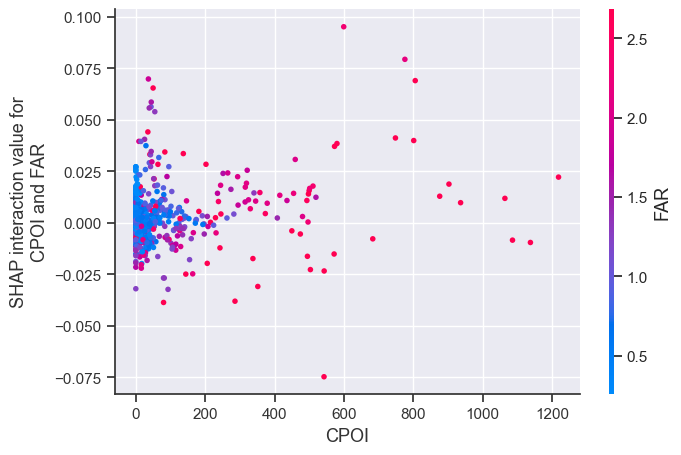

In [208]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("CPOI","FAR"),
    shap_interaction, X_coords,
    display_features=X_coords)